In [98]:
from keras.models import load_model
from create_model import create_base_network, in_dim, tripletize, std_triplet_loss
from keras.optimizers import SGD
import testing as T
import config as C
import os
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import matplotlib.patheffects as PathEffects
%matplotlib inline


def get_vectors(model, tdir=C.test_dir):
    classes = os.listdir(tdir)
    res = {}
    print('Embedding images...')
    for c in classes:         
            print(c)
            images = os.listdir(os.path.join(tdir,c))
            res[c] = [T.class_file(model, os.path.join(tdir,c,f)) for f in images]
    print('Done embedding images.')
    return res


model_file = 'models/epoch_20.model'
print('Loading model from '+ model_file + '...')

base_model = load_model(model_file)

print('Compiling model...')
model = tripletize(base_model)    
model.compile(optimizer=SGD(lr=C.learn_rate, momentum=0.9),
              loss=std_triplet_loss())

vs = get_vectors(base_model, C.val_dir)


Using TensorFlow backend.


Loading model from models/epoch_20.model...


/home/havard/.local/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Compiling model...
Embedding images...
Penilia
Limacinidae
eudoxie__Diphyidae
Temoridae
Oncaeidae
Salpida
Euchaetidae
gonophore__Diphyidae
Noctiluca
Eucalanidae
Fritillariidae
zoea__Decapoda
nectophore__Diphyidae
Foraminifera
multiple__other
Phaeodaria
Harpacticoida
Ostracoda
nauplii__Crustacea
nauplii__Cirripedia
Oikopleuridae
Haloptilus
tail__Chaetognatha
Evadne
tail__Appendicularia
multiple__Copepoda
egg__other
Done embedding images.


In [99]:
from sklearn.svm import SVC

df = pd.DataFrame()
classes = os.listdir(C.val_dir)
for c in classes:
    class_df = pd.DataFrame(np.asarray(vs[c]).reshape(100,64))
    class_df.insert(column='species', loc=0, value=c)    
    df = df.append(class_df)

df = df.reset_index()
df = df.drop(['index'], axis=1)

le = preprocessing.LabelEncoder()
le.fit(df['species'])

X = np.asarray(df.drop(['species'],axis=1).values)
y = np.asarray(le.transform(df['species'].values))
# Train SVM on validation data

svc_clf = SVC(kernel='poly', degree=3, probability=False, C=1e-4, gamma=1e-5, verbose=True,cache_size=16000)
svc_clf.fit(X,y)

print(svc_clf.get_params)


[LibSVM]<bound method BaseEstimator.get_params of SVC(C=0.0001, cache_size=16000, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1e-05, kernel='poly',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=True)>


In [101]:
val_data = pd.DataFrame(X)
val_data.insert(0, 'species',le.inverse_transform(y))
val_data.to_csv('validation.csv')

In [102]:
test_vs = get_vectors(base_model, C.test_dir)


Embedding images...
Penilia
Limacinidae
eudoxie__Diphyidae
Temoridae
Oncaeidae
Salpida
Euchaetidae
gonophore__Diphyidae
Noctiluca
Eucalanidae
Fritillariidae
zoea__Decapoda
nectophore__Diphyidae
Foraminifera
multiple__other
Phaeodaria
Harpacticoida
Ostracoda
nauplii__Crustacea
nauplii__Cirripedia
Oikopleuridae
Haloptilus
tail__Chaetognatha
Evadne
tail__Appendicularia
multiple__Copepoda
egg__other
Done embedding images.


In [131]:
df = pd.DataFrame()
classes = os.listdir(C.test_dir)
for c in classes:
    n_samples = np.shape(test_vs[c])[0]
    class_df = pd.DataFrame()
    class_df = pd.DataFrame(np.asarray(test_vs[c]).reshape(n_samples,64))
    class_df.insert(column='species', loc=0, value=c)    
    df = df.append(class_df)
    
df = df.reset_index()
df = df.drop(['index'], axis=1)

X_test = np.asarray(df.drop(['species'],axis=1).values)
y_test = np.asarray(le.transform(df['species'].values))

test_data = pd.DataFrame(X_test)
test_data.insert(0, 'species',le.inverse_transform(y_test))
test_data.to_csv('testing.csv')



Accuracy accuracy: 0.74703
                       precision    recall  f1-score   support

          Eucalanidae       0.85      0.86      0.86       100
          Euchaetidae       0.90      0.65      0.76       100
               Evadne       0.95      0.75      0.84       100
         Foraminifera       0.62      0.74      0.68       100
       Fritillariidae       0.80      0.82      0.81       100
           Haloptilus       0.92      0.95      0.94       100
        Harpacticoida       0.61      0.74      0.67       100
          Limacinidae       0.60      0.68      0.64       100
            Noctiluca       0.83      0.97      0.89       100
        Oikopleuridae       0.76      0.81      0.78       100
            Oncaeidae       0.71      0.77      0.74       100
            Ostracoda       0.86      0.86      0.86       100
              Penilia       0.92      0.93      0.93       100
           Phaeodaria       0.90      0.84      0.87       100
              Salpida    

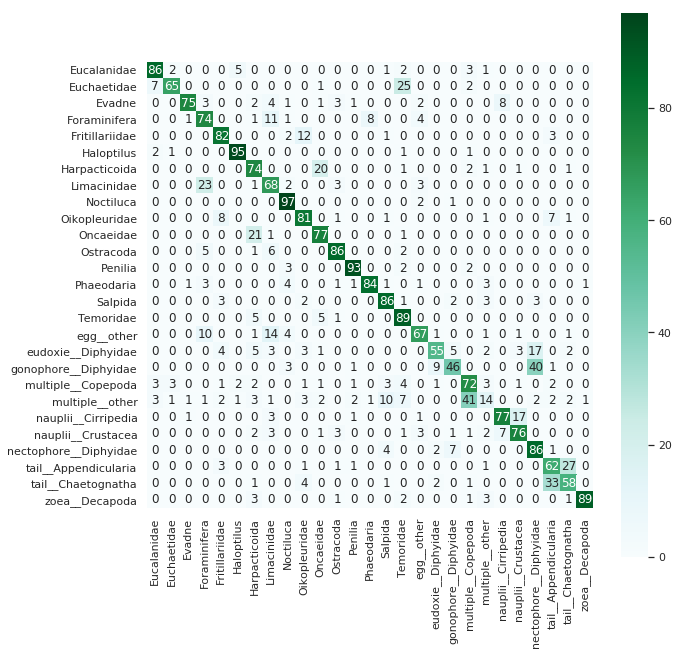

In [133]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

y_pred = svc_clf.predict(X_test)
y_pred_label = le.inverse_transform(y_pred)
y_test_label = le.inverse_transform(y_test)

#make row index dict
row_names = {}
for i in range(0,27):
    row_names[i] = le.inverse_transform([i])[0]
    
mat = pd.DataFrame(confusion_matrix(y_test_label, y_pred_label))
mat.columns = le.inverse_transform(range(0,27))
mat.rename(index=row_names, inplace=True)

acc = accuracy_score(y_test,y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.set()
accuracy_report = str('\n\n{} accuracy: {:.5f}'.format("Accuracy", acc))
print(accuracy_report)
sns.heatmap(mat, square=True, annot=True, fmt='d', cmap='BuGn')
crep = classification_report(y_test_label, y_pred_label)
print(crep)

In [134]:
import pandas as pd
from sklearn import cluster

X_val = pd.read_csv('validation.csv', index_col=0).drop('species',axis=1)

kmeans = cluster.MiniBatchKMeans(n_clusters=27)
kmeans.fit(X_val)


MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
        init_size=None, max_iter=100, max_no_improvement=10, n_clusters=27,
        n_init=3, random_state=None, reassignment_ratio=0.01, tol=0.0,
        verbose=0)

In [135]:
import numpy as np
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

X_test = pd.read_csv('testing.csv', index_col=0)
le.fit(np.unique(X_test['species']))
y_test = np.asarray(le.transform(X_test['species']))
X_test.drop('species', axis=1, inplace=True)
X_test = np.asarray(X_test)

/home/havard/anaconda3/envs/inf368/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/havard/anaconda3/envs/inf368/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)




Accuracy: 0.62611
                       precision    recall  f1-score   support

          Eucalanidae       0.89      0.85      0.87       100
          Euchaetidae       0.88      0.71      0.78       100
               Evadne       0.87      0.75      0.81       100
         Foraminifera       0.55      0.77      0.64       100
       Fritillariidae       0.00      0.00      0.00       100
           Haloptilus       0.94      0.94      0.94       100
        Harpacticoida       0.00      0.00      0.00       100
          Limacinidae       0.52      0.56      0.54       100
            Noctiluca       0.82      0.96      0.88       100
        Oikopleuridae       0.43      0.83      0.57       100
            Oncaeidae       0.45      0.96      0.62       100
            Ostracoda       0.90      0.84      0.87       100
              Penilia       0.97      0.83      0.89       100
           Phaeodaria       0.91      0.85      0.88       100
              Salpida       0.84  

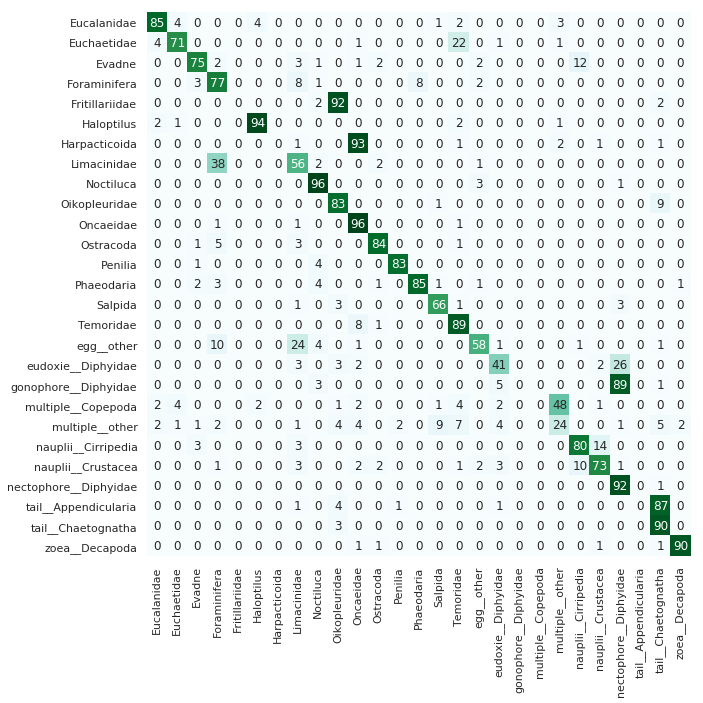

In [136]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

y_pred_list = []
y_test_list = []

cclass = []

for i in range(0,27):
    
    y_pred = kmeans.predict(X_test[np.where(y_test==i)])
    y_pred_list.extend(y_pred)
    y_test_list.extend(y_test[np.where(y_test==i)])
    top_class = np.argmax(np.bincount(y_pred))
    cclass.extend([top_class])
    
# make a dictionary from cluster index to most probable name

realname = {}
for i in range(0,27):
    realname[cclass[i]] = le.inverse_transform([i])[0]    
    
y_test_label = le.inverse_transform(np.asarray(y_test_list))


for i in range(0, len(y_pred_list)):
    if (y_pred_list[i] in realname):
       y_pred_label[i] = realname[y_pred_list[i]]
    else:
        y_pred_label[i] = 'Unknown'


cm= confusion_matrix(y_test_label, y_pred_label, labels=np.unique(y_test_label))

mat = pd.DataFrame(cm, index=np.unique(y_test_label))

mat.columns= np.unique(y_test_label)
mat.reindex(np.unique(y_test_label))
acc = accuracy_score(y_test_label,y_pred_label)
crep = classification_report(y_test_label, y_pred_label)
fig, ax = plt.subplots(figsize=(10,10))
sns.set()
accuracy_report = str('\n\n{}: {:.5f}'.format("Accuracy", acc))
print(accuracy_report)
sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False, cmap='BuGn')
print(crep)